<a href="https://colab.research.google.com/github/roshangeoroy/NerualBeliefPropagation/blob/main/neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing Necessary modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


In [ ]:
#configuring GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    gpu_num = 0 
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

In [ ]:
# Importing Sionna and componenets
import os
os.system("pip install sionna")
import sionna


from sionna.fec.ldpc import LDPCBPDecoder
from sionna.utils.metrics import BitwiseMutualInformation
from sionna.fec.utils import GaussianPriorSource, load_parity_check_examples
from sionna.utils import ebnodb2no, hard_decisions
from sionna.utils.metrics import compute_ber
from sionna.utils.plotting import PlotBER

#loss function
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
class WeightedBP(tf.keras.Model):
    def __init__(self, pcm, num_iter=5):
        super().__init__()

        # init components    
        self.decoder = LDPCBPDecoder(pcm,num_iter=1,stateful=True,hard_out=False,cn_type="boxplus",trainable=True) 

        # used to generate llrs during training (see example notebook on all-zero codeword trick)
        self.llr_source = GaussianPriorSource()
        self._num_iter = num_iter

        self._bce = BinaryCrossentropy(from_logits=True)

    def call(self, batch_size, ebno_db):     
        noise_var = ebnodb2no(ebno_db,
                              num_bits_per_symbol=2, # QPSK
                              coderate=coderate)        
        
        # all-zero CW to calculate loss / BER
        c = tf.zeros([batch_size, n]) 

        # Gaussian LLR source
        llr = self.llr_source([[batch_size, n], noise_var])
        print(llr)

        # --- implement multi-loss as proposed by Nachmani et al. [1]---
        loss = 0 
        msg_vn = None # internal state of decoder
        for i in range(self._num_iter):
            c_hat, msg_vn = self.decoder((llr, msg_vn)) # perform one decoding iteration; decoder returns soft-values
            loss += self._bce(c, c_hat)  # add loss after each iteration
        loss /= self._num_iter # scale loss by number of iterations        

        return c, c_hat, loss


In [ ]:
#@title Fixing Parameters {run: "auto"}
pcm_id = 2
pcm, k , n, coderate = load_parity_check_examples(pcm_id=pcm_id, verbose=True)
np.save('PCM',pcm)

num_iter = 10 # set number of decoding iterations

# and initialize the model
model = WeightedBP(pcm=pcm, num_iter=num_iter)


n: 127, k: 106, coderate: 0.835


Total number of weights:  1008


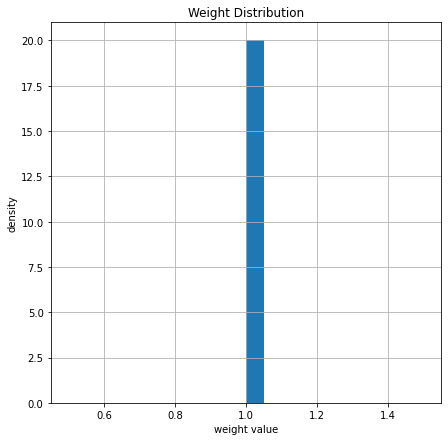

In [ ]:
# count number of weights/edges
print("Total number of weights: ", np.size(model.decoder.get_weights()))

# and show the weight distribution
model.decoder.show_weights()

tf.Tensor(
[[  0.6069975   -2.6291876   -7.032379   ...  -4.127503    -5.179115
   -6.58302   ]
 [-11.699417    -6.5385475   -2.9122987  ...  -8.654228    -5.40008
   -2.364616  ]
 [ -4.1966143    0.58211374  -2.6267233  ...  -5.5246687   -8.580891
   -4.081333  ]
 ...
 [ -3.7231114    0.06858063  -2.781547   ...  -1.8712695   -4.326932
   -5.034563  ]
 [ -5.8165984   -6.301092    -1.9847944  ...  -7.966694    -3.795526
   -1.1510665 ]
 [ -3.7017012   -6.620448    -4.759138   ...   2.6444325   -7.5573206
   -0.6731267 ]], shape=(1000, 127), dtype=float32)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 7.3157e-02 | 1.0000e+00 |        9291 |      127000 |         1000 |        1000 |         0.3 |reached target bit errors
tf.Tensor(
[[ -5.233515    -5.7992806   -1.930836

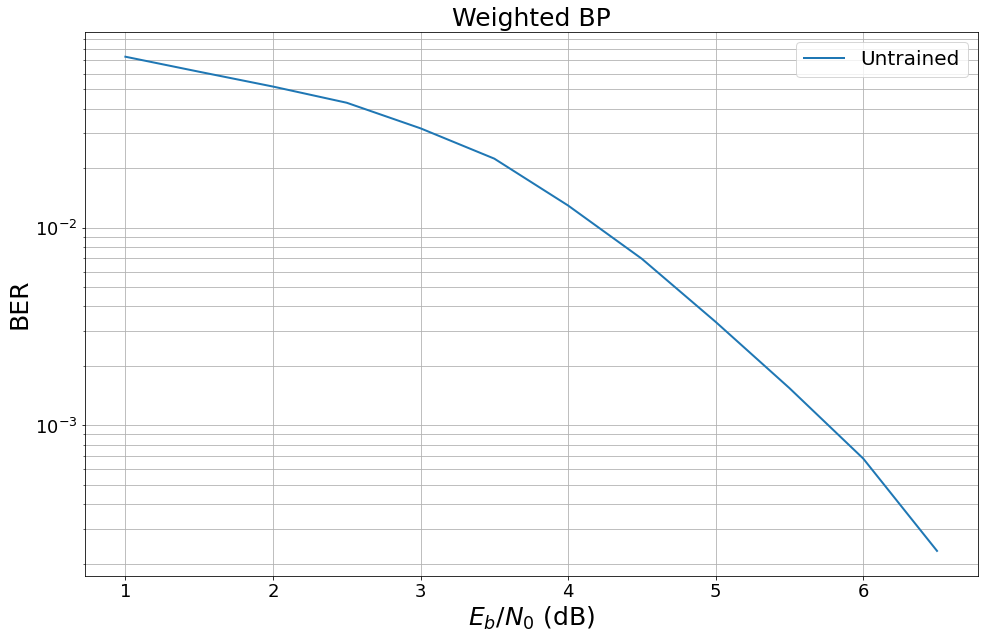

In [ ]:

# SNR to simulate the results
ebno_dbs = np.array(np.arange(1, 7, 0.5))
mc_iters = 100 # number of Monte Carlo iterations

# we generate a new PlotBER() object to simulate, store and plot the BER results
ber_plot = PlotBER("Weighted BP")

# simulate and plot the BER curve of the untrained decoder
ber_plot.simulate(model,
                  ebno_dbs=ebno_dbs,
                  batch_size=1000,
                  num_target_bit_errors=2000, # stop sim after 2000 bit errors
                  legend="Untrained",
                  soft_estimates=True,
                  max_mc_iter=mc_iters,
                  forward_keyboard_interrupt=False);


In [ ]:

# training parameters
batch_size = 1000
train_iter = 500
ebno_db = 4.0
clip_value_grad = 10 # gradient clipping for stable training convergence

# bmi is used as metric to evaluate the intermediate results
bmi = BitwiseMutualInformation()

# try also different optimizers or different hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) 

for it in range(0, train_iter):
    with tf.GradientTape() as tape:
        b, llr, loss = model(batch_size, ebno_db)     

    grads = tape.gradient(loss, model.trainable_variables)
    grads = tf.clip_by_value(grads, -clip_value_grad, clip_value_grad, name=None)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    # calculate and print intermediate metrics
    # only for information
    # this has no impact on the training
    if it%10==0: # evaluate every 10 iterations
        # calculate ber from received LLRs
        b_hat = hard_decisions(llr) # hard decided LLRs first
        ber = compute_ber(b, b_hat) 
        # and print results
        mi = bmi(b, llr).numpy() # calculate bit-wise mutual information
        l = loss.numpy() # copy loss to numpy for printing
        print(f"Current loss: {l:3f} ber: {ber:.4f} bmi: {mi:.3f}".format())
        bmi.reset_states() # reset the BMI metric


Streaming output truncated to the last 5000 lines.
 [ -7.080622    -9.106613    -0.64922094 ... -10.356476   -12.442902
  -11.3767805 ]
 ...
 [-10.350984   -13.069983    -9.525182   ...  -8.615279   -10.725452
   -9.776434  ]
 [ -6.4893904   -9.395398    -7.040532   ...  -2.2901797  -17.459038
   -4.711446  ]
 [ -9.586301    -8.942537    -4.4080315  ... -12.752079    -5.0504975
   -7.534489  ]], shape=(1000, 127), dtype=float32)
tf.Tensor(
[[ -7.8903384 -11.413312   -6.469461  ...  -4.567219   -6.1608167
   -6.77202  ]
 [ -5.3306656 -16.252754   -2.3446941 ...  -8.339473  -14.055964
   -7.377358 ]
 [ -8.353927  -17.726074   -4.4210477 ...  -7.90009    -8.9148035
   -9.358978 ]
 ...
 [ -2.010373  -13.398337   -7.334241  ...  -8.522061  -17.214012
   -6.355964 ]
 [ -5.994588   -8.065638   -8.089754  ...  -9.807634   -0.994153
   -9.101946 ]
 [ -6.75589   -12.49332    -9.163329  ... -18.044468   -7.047281
   -8.25108  ]], shape=(1000, 127), dtype=float32)
tf.Tensor(
[[ -4.2283597  -8.0566

tf.Tensor(
[[-4.1932654  -7.506343   -6.5668173  ... -4.584571   -5.8040266
  -2.0726573 ]
 [-6.2296944  -4.229149   -8.325954   ...  0.4648862   0.7665224
  -2.4197855 ]
 [ 1.0857549  -3.2609758  -1.7632403  ... -0.17581558 -6.5570774
  -5.857393  ]
 ...
 [-9.60051     0.93297195 -3.423507   ... -7.9053564  -1.876867
  -5.432503  ]
 [ 0.14038086 -4.9073243   0.4798088  ... -6.555086    0.15713501
  -3.083726  ]
 [-2.2915685  -3.482976   -3.898575   ... -0.24508762 -7.6902475
  -5.99754   ]], shape=(1000, 127), dtype=float32)
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 7.3591e-02 | 9.9900e-01 |        9346 |      127000 |          999 |        1000 |         0.3 |reached target bit errors
tf.Tensor(
[[ -6.640378    -4.3387303   -3.2623708  ...  -5.826568    -5.548562

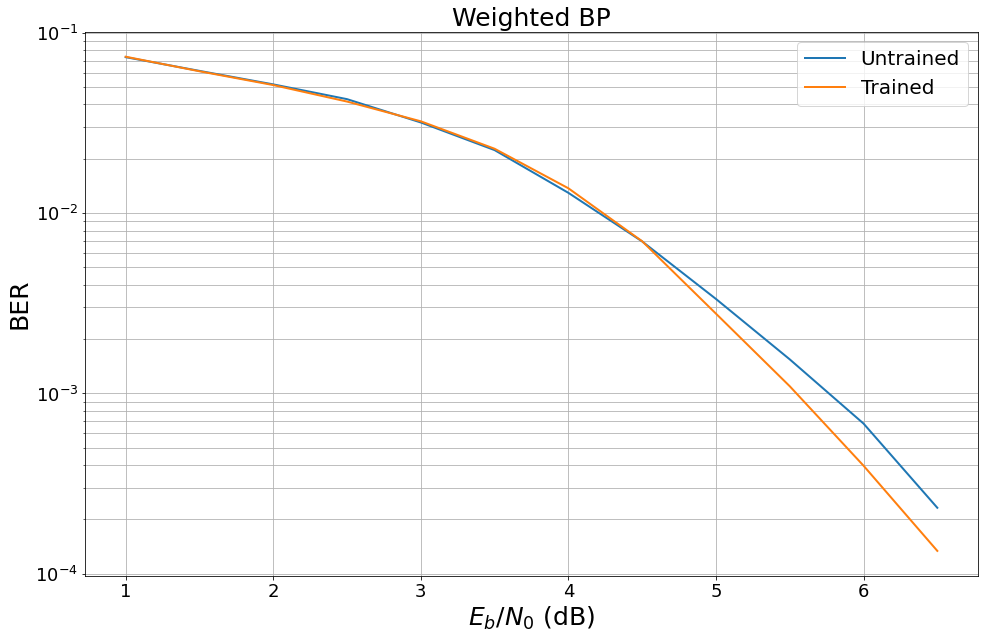

In [ ]:
#analysing trained BP decoder
ebno_dbs = np.array(np.arange(1, 7, 0.5))
batch_size = 10000
mc_ites = 100

ber_plot.simulate(model,
                  ebno_dbs=ebno_dbs,
                  batch_size=1000,
                  num_target_bit_errors=2000, # stop sim after 2000 bit errors
                  legend="Trained",
                  max_mc_iter=mc_iters,
                  soft_estimates=True);

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
t=np.linspace(0,np.pi,100)
#Bit Generation
def bitG(a):
  b=np.random.randint(low=0,high=2,size=a)
  return b
def power(s):
  s=np.linalg.norm(s)/s.size
  return s
def energy(s):
  s=np.linalg.norm(s)
  return s
#Carrier Generation (Normalised)
def car(phase):
  c=np.cos((2*np.pi*t)-phase)
  e=np.linalg.norm(c)
  nc=c/e
  return nc
#BPSK of bit stream
def bpsk(a,nc):
  l=np.array([])
  for bit in a:
    if bit==0:
       l=np.concatenate([l,-nc],axis=0)
    else:
       l=np.concatenate([l,nc],axis=0)
  return l
#Trasmission through Channel
def awgn(k,sigma):
  n=np.random.normal(0,sigma,k.size)
  k=k+n 
  return k
#demodulation
def demod(l,nc):  
  z=len(l)
  y=len(nc)
  h=[]
  con=np.split(l,z/y)
  for ar in con:
      h.append(np.sum(nc*ar))
  h=np.array(h)
  return h

In [ ]:
#@title Generating Random Bits and encoding it using the PCM
#@markdown ### Check the box for Random Input :
c=True #@param {type:"boolean"}
g=[]
if c:
  encoder = sionna.fec.linear.encoding.LinearEncoder(load_parity_check_examples(2)[0], is_pcm=True)
  binary_source = sionna.utils.BinarySource()
  b = binary_source([1,k])
  print('Input Random Word : \n')
  print(np.array(b)[0])
  g=np.array(b)[0]
  xc = np.array(encoder(b))
  xd=xc[0]
else:
  #@markdown ### Custom Input from user:
  input_array = [[0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,]] #@param {type:"raw"}
  input_array=tf.convert_to_tensor(input_array, dtype=tf.float32)
  xc = np.array(encoder(input_array))
  print('Input Word : \n')
  print(np.array(input_array)[0])
  g=np.array(input_array)[0]
  xd=xc[0]

print("\nEncoded Code Word : \n")
print(xd)


Input Random Word : 

[1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 1.]

Encoded Code Word : 

[0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 0.]


In [ ]:
#@title Run this Cell for BPSK modulation [AWGN channel]
B=xd
c=car(0)
i=bpsk(B,c)
i=awgn(i,np.sqrt(0.22135943))
i=demod(i,c)
print('Output Encoded Codeword after passing through an AWGN channel [Noise is added]')
# l=1
# for a in i:
#   l=l+1
#   print(np.round(a,decimals=3),end=', ')
#   if l%24==0:
#     print('')
print(i)
llrz= [2*x/0.22135943 for x in i]



Output Encoded Codeword after passing through an AWGN channel [Noise is added]
[-0.47698467 -1.28828276  1.10965365 -1.41111831 -0.91177242 -1.10035651
 -0.4585128   0.54451197  1.09450688  1.28659066  2.01635736  1.5286932
 -1.350376    1.14965101 -0.08525148  1.27616626 -1.06961005  0.66793349
  0.99852688 -0.95667915 -0.4760366  -0.6029755  -1.46824622  1.02480601
  1.36249333 -1.87285495 -1.2171153  -0.81460951 -1.38159293 -0.10668567
  1.35610355  0.7110254  -0.62810629  1.1598323  -0.53810755 -1.7270442
 -0.17030221 -1.65024188 -1.30664979  0.99167538 -0.82733997  0.98364158
  2.03247469 -0.66652791 -1.41285927 -0.47292883 -1.10637702  1.92944969
 -0.50361739 -1.10825711 -1.37546432  1.06838381  0.58247447  0.81389175
  1.187014   -1.25818145 -1.54333948 -0.97091652  0.72160407  0.70921125
  1.33166072  0.5702696  -0.83028168 -1.05555759 -0.60062839  1.16384209
  1.44710312 -1.90512568  0.58646995  0.98185427 -0.69593023 -0.92601751
 -0.67996386 -2.0598341   1.29273868 -0.6049524

In [ ]:
#@title Run this Cell to get the decoded posterior LLRs after all the iterations.
z=model.decoder((llrz,None))[0]

In [ ]:
Z_hat = hard_decisions(z)

In [ ]:
#@title Summarizing
print("Input Code Word:")
print(g)
finaloutput1=Z_hat[106:127:]
finaloutput2=Z_hat[21:106:]
final=np.concatenate([finaloutput1,finaloutput2])
print('Final Decoded bits:')
print(final)

Input Code Word:
[1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 1.]
Final Decoded bits:
[1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 1. 1. 1.]


In [ ]:
final-g

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.], dtype=float32)

In [ ]:
def error(i,o):
  return np.average(np.abs(i-o))
print('BER evaluted:')
error(final,g)

BER evaluted:


0.009433962